# Molecular Formulas

In cheminformatics, the typical way of representing a molecule is with a SMILES string such as `CCO` for ethanol. A SMILES string can be converted into a molecular graph which notes which atoms are attached to each other using which bond types, which is very useful for determining molecular structure and related properties.

However, there are still cases where the molecular formula such as C<sub>2</sub>H<sub>6</sub>O is useful. For example, the molecular formula is sufficient to determine the molecular mass, to calculate the predicted results from an elemental analysis, or simply to get a sense for the elemental composition of a given molecule.

I'm working on a blog post where I needed to calculate the molecular formula including isotopes. I was unable to find a package that produced molecular formulas from SMILES strings, so I wrote a function to do so.

In [31]:
# !pip install rdkit

In [46]:
from collections import defaultdict
from IPython.display import display, Markdown

from rdkit import Chem

## Set up

Because RDKit excludes hydrogen atoms by default, but we want to include hydrogens in our molecular formula, we tell RDKit to add hydrogens.

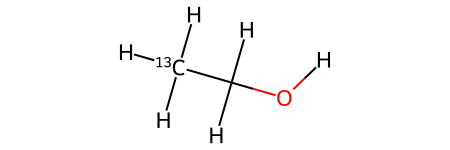

In [44]:
# Ethanol, no isotopes
sml = "CCO"

# Ethanol, with isotopes
sml = "[13CH3]CO"
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
mol

In [34]:
def composition(
        molecule: Chem.Mol,
        isotopes=False):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if not molecule:
        return

    # Add hydrogen atoms--RDKit excludes them by default
    molecule = Chem.AddHs(molecule)
    comp = defaultdict(lambda: 0)

    # Get atom counts
    for atom in molecule.GetAtoms():
        element_symbol = atom.GetSymbol()
        # If isotopes not requested, simply count the number of atoms of each element
        if not isotopes:
            comp[element_symbol] += 1
        # If isotopes requested, count the number of each isotope of each element
        else:
            isotope = atom.GetIsotope()
            try:
                comp[element_symbol][isotope] += 1
            except:
                comp[element_symbol] = defaultdict(lambda: 0)
                comp[element_symbol][isotope] += 1
    return comp

In [35]:
ethanol = Chem.AddHs(Chem.MolFromSmiles("CCO"))

In [36]:
ethanol_isotope = Chem.AddHs(Chem.MolFromSmiles("[13CH3]CO"))

In [37]:
composition(ethanol_isotope)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'C': 2, 'O': 1, 'H': 6})

In [38]:
composition(ethanol_isotope, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'C': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {13: 1, 0: 1}),
             'O': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 1}),
             'H': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 6})})

In [102]:
def smiles_to_formatted_formula(smiles, isotopes=False):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        comp = composition(mol, isotopes)

        formula = {'markdown': "", 'dollar_math': "", 'latex': ""}

        if isotopes:
            isotopes_dict = defaultdict(lambda: defaultdict(str))
            subscripts = defaultdict(lambda: defaultdict(int))
            superscripts = defaultdict(list)

            for element, counts in comp.items():
                for isotope, count in counts.items():
                    if count > 1:
                        subscripts[element][isotope] = count
                    if isotope != 0:
                        superscripts[element].append(isotope)

                    isotopes_dict[element][isotope] = 1
                # Sort the element's isotopes from lowest to highest
                superscripts[element].sort()

            sorted_element_keys = sorted(isotopes_dict.keys())
            for element in sorted_element_keys:
                isotope_count_pairs = isotopes_dict[element]
                # Sort the element's isotopes from lowest to highest
                sorted_isotope_keys = sorted(isotope_count_pairs.keys())
                for isotope in sorted_isotope_keys:
                    if element in superscripts:
                        if isotope in superscripts[element]:
                            formula["markdown"] += f"<sup>{isotope}</sup>"
                            formula["dollar_math"] += r"$^{{{}}}$".format(isotope)
                            formula["latex"] += "^{{{}}}".format(isotope)
                    formula["markdown"] += element
                    formula["dollar_math"] += r"{}".format(element)
                    formula["latex"] += element
                    if element in subscripts:
                        if isotope in subscripts[element]:
                            for isotope, isotope_count in subscripts[element].items():
                                formula["markdown"] += f"<sub>{isotope_count}</sub>"
                                formula["dollar_math"] += r"$_{{{}}}$".format(isotope_count)
                                formula["latex"] += "_{{{}}}".format(isotope_count)
            formula["latex"] = "$" + formula["latex"] + "$"
        else:
            # Handling the case when isotopes is False
            sorted_element_keys = sorted(comp.keys())

            for element in sorted_element_keys:
                count = comp[element]
                formula["markdown"] += element
                formula["dollar_math"] += r"{}".format(element)
                formula["latex"] += element
                if count > 1:
                    formula["markdown"] += f"<sub>{count}</sub>"
                    formula["dollar_math"] += r"$_{{{}}}$".format(count)
                    formula["latex"] += "_{{{}}}".format(count)
            formula["latex"] = "$" + formula["latex"] + "$"

        return formula
    else:
        return "Invalid SMILES"

In [99]:
isotope_formula = smiles_to_formatted_formula("[13CH3]CO", isotopes=True)
Markdown(isotope_formula["latex"])

$C^{13}CH_{6}O$

In [104]:
no_isotope_formula = smiles_to_formatted_formula("[13CH3]CO", isotopes=False)
no_isotope_formula["latex"]
Markdown(no_isotope_formula["latex"])

$C_{2}H_{6}O$

In [59]:
isotope_formula["dollar_math"]

'C$^{13}$CH$_{6}$O'

In [91]:
# latex = "$E=mc^2$"
latex =  "$^{12}C$"
latex = "$^{12}C_{2}^{13}C^{14}C_{3}$"
Markdown(latex)


$^{12}C_{2}^{13}C^{14}C_{3}$